In [86]:
import networkx as nx
import networkx.algorithms.community as nx_comm

from utilities import import_networks
from community import community_louvain
from networkx.algorithms.community import greedy_modularity_communities

# from networkx.algorithms.community.centrality import girvan_newman
# from networkx.algorithms.community import lukes_partitioning

import matplotlib.pyplot as plt
import numpy as np

from tqdm.notebook import tqdm

In [44]:
networks = import_networks()

print("\n".join([str(x) for x in networks]))

Graph with 1001 nodes and 75862 edges
Graph with 999 nodes and 75415 edges
Graph with 1025 nodes and 80306 edges
Graph with 1018 nodes and 80077 edges


## Finding Communities
---

In [46]:
# Adding self nodes
def add_self_loop(G,r: int):
    for node in G.nodes():
        G.add_edge(node,node,weight=r)

def get_communities(G,resolution):
    add_self_loop(G,resolution)
    comms = greedy_modularity_communities(G,resolution=1, weight="weight")
    return comms

## Test resolution parameter

In [57]:
# list(networks[0].edges(data=True))
for g in networks:
    add_self_loop(g,0)
total_degrees = [sum(dict(g.degree(weight="weight")).values()) for g in networks]
total_degrees = [sum([edge[2]["weight"] for edge in g.edges(data=True)]) for g in networks]

rmin = [int(-w/g.number_of_nodes()) for w,g in zip(total_degrees,networks)]
print(rmin)

[-506, -507, -628, -648]


In [29]:
%%time
comms = [get_communities(G,r) for G,r in zip(networks,rmin)]

CPU times: user 33.1 s, sys: 33.1 ms, total: 33.1 s
Wall time: 33.2 s


In [39]:
communities_by_resolution =  dict(zip(range(2018,2022),[{},{},{},{}]))
print(communities_by_resolution)

{2018: {}, 2019: {}, 2020: {}, 2021: {}}


In [169]:
%%time
# resolutions = np.unique(np.linspace(-620,100,200, dtype=int))
resolutions = [0]
# print(resolutions.size)
for resolution in tqdm(resolutions):
    for g,year in zip(networks,range(2018,2022)):
        communities_by_resolution[year][resolution] = [list(y) for y in get_communities(g,resolution=resolution)]

  0%|          | 0/1 [00:00<?, ?it/s]

CPU times: user 32.1 s, sys: 6.64 ms, total: 32.1 s
Wall time: 32.2 s


In [176]:
len(communities_by_resolution[2020][0])

8

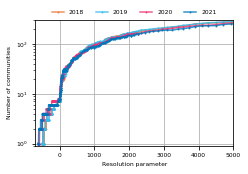

In [165]:
#Visualize statistics
colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    

cm = 1/2.54
fig,ax = plt.subplots(figsize=(8.7*cm,0.7*8.7*cm))

ax.set(xscale="linear", yscale="log",xlim=(-700,5_000),ylim=(0.9,300),
       xlabel="Resolution parameter", ylabel="Number of communities")
for year, r in zip(range(2018,2022),rmin):
    n_comms = [len(y) for x,y in communities_by_resolution[year].items() if x > r]
    resolutions = [int(x) for x,y in communities_by_resolution[year].items() if x > r]
    
    resolutions,n_comms = list(zip(*sorted(list(zip(resolutions,n_comms)), key=lambda x: x[0])))

    ax.plot(resolutions,n_comms,marker="o",ls="-",markersize=1, label=year, c=colors[year],alpha=0.8)
    
ax.grid()
ax.legend(ncol=4,bbox_to_anchor=(0.5,1),loc="lower center",frameon=False)
plt.tight_layout()
plt.savefig("images/arenas_community_N.pdf")
# ax.legend()

In [178]:
# Export Data
import json
for year in range(2018,2022):
    keys = [int(x) for x in communities_by_resolution[year].keys()]
    communities_by_resolution[year] = dict(zip(keys, communities_by_resolution[year].values()))
with open("data/arenas_communities.json", "w") as f:
    json.dump(communities_by_resolution,f)


In [36]:
#Import data
import json
def keystoint(x):
    return {int(k): v for k, v in x.items()}
with open("data/arenas_communities.json", "r") as f:
    communities_by_resolution = json.load(f, object_hook=keystoint)


In [34]:
#Classify Communities
communities_statistics = {}
for (year,comms),g,r in  zip(communities_by_resolution.items(),networks,resolutions):
    communities_statistics[year] = {"N_communities":    [len(x) for x in comms],
                                    "Avg_comm_size":    [np.average([len(y) for y in x]) for x in comms],
                                    "Sigma_comm_size":  [np.std([len(y) for y in x]) for x in comms],
                                    "Median_comm_size": [np.median([len(y) for y in x]) for x in comms],
                                    "Modularity_score": [nx_comm.modularity(g,c,resolution=r,weight='weight') for c in comms]}

## Visualize Data
---

In [6]:
#Import data
import json
with open("data/modularity_communities_statistics.json", "r") as f:
    communities_statistics = json.load(f)
with open("data/modularity_communities.json", "r") as f:
    communities_by_resolution = json.load(f)

resolutions = np.append(np.arange(0,1,0.2),np.arange(1,25,0.5))

/tmp/ipykernel_3223/1572019614.py:30: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  a.set(xlim=(0,20),ylim=(0,a.get_ylim()[1]))


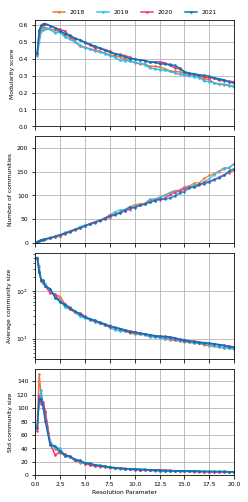

In [5]:
#Visualize statistics
colors = ['#EE7732', '#33BBEE',  '#EE3377',  '#0077BB']
colors = dict(zip(range(2018,2022),colors))

plt.rcParams.update({'font.size': 6})
plt.rc('xtick', labelsize=6)    # fontsize of the tick labels
plt.rc('ytick', labelsize=6)    
plt.rc('axes', titlesize=6)    


cm = 1/2.54
fig,ax = plt.subplots(ncols=1,nrows=4,figsize=(8.7*cm,2*8.7*cm),sharex=True)
fig.text(0.5, 0.00, 'Resolution Parameter', ha='center')

ax[0].set(ylabel="Modularity score",yscale="linear")
ax[1].set(ylabel="Number of communities")
# # ax[0,1].set(xlabel="Resolution parameter", ylabel="Median community size")
ax[2].set( ylabel="Average community size",yscale="log")
ax[3].set( ylabel="Std community size",yscale="linear")
for year, data in communities_statistics.items():
    ax[0].plot(resolutions[1:],data["Modularity_score"][1:],label=year, marker='o', ms=1.5, color = colors[int(year)])
    ax[1].plot(resolutions[1:],data["N_communities"][1:],label=year, marker='o', ms=1.5,alpha=0.8, color = colors[int(year)])
    # ax[0,1].plot(resolutions,data["Median_comm_size"],label=year, marker='o', ms=3, color = colors[int(year)])
    ax[2].plot(resolutions[1:],data["Avg_comm_size"][1:],label=year, marker='o', ms=1.5, color = colors[int(year)])
    ax[3].plot(resolutions[1:],data["Sigma_comm_size"][1:],label=year, marker='o', ms=1.5, color = colors[int(year)])
             

for a in ax.flatten():
    a.grid()
    a.set(xlim=(0,20),ylim=(0,a.get_ylim()[1]))
    # a.set_xticks(a.get_xticks())
    # a.set_xticklabels(a.get_xticklabels(),fontdict={"fontsize":6})
    # a.legend()
# ax[0,0].grid()
# ax[0,1].grid()
ax[0].legend(ncol=4,bbox_to_anchor=(0.5,1),loc="lower center",frameon=False)
# ax[0,1].legend()
plt.tight_layout()
plt.savefig("modularity_community_statistics.pdf")
# plt.savefig("modularity_community_statistics.png",dpi=200)

In [ ]:
from scipy.stats import linregress

fits = []
for year, data in communities_statistics.items():
    fits.append(linregress(resolutions, data["N_communities"]))
    print(fits[-1])
    # print(f"\\SI{{{fits[-1].slope}({fits[-1].stderr})}}{{}} & \\SI{{{fits[-1].intercept}({fits[-1].intercept_stderr})}}{{}} & {fits[-1].rvalue}\\\\")#, str(fits[-1].intercept),str(fits[-1].pvalue)]))

In [ ]:
from scipy.stats import norm

In [ ]:
fig,ax = plt.subplots(figsize=(10,5))
ax.set(xlabel="Community size", ylabel="p")

x = np.linspace(0,150,200)
for average,std in zip(communities_statistics[2018]["Avg_comm_size"],communities_statistics[2018]["Sigma_comm_size"]):
    ax.plot(x,norm(loc=average,scale=std).pdf(x),label=year, marker='',ls='-', ms=3)
             
ax.grid()
# ax.legend()

In [55]:
# Find matching communities OLD
_ ="""
def enumerate_simmilarity(d1,d2):
    scores = []
    simmilarity = lambda d,d1: len(d1.keys() & d.keys()) * sum([d1[c]*d[c]/(1+abs(d1[c]-d[c])) for c in (d1.keys() & d.keys())])
    for d in d1:
        scores.append([simmilarity(d,dd) for dd in d2])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(d1),-1)
        
    for i in range(len(d1)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1
        scores[:,index[1]] = -1
     
    return list(zip(best,d1))
"""

In [14]:
# Find matching communities NEW
def enumerate_simmilarity(enum, min_courses, max_courses):
    scores = []
    simmilarity = lambda x, y: len(set(x) & set(y))**2 /(1 + len(set(x) - set(y)) + len(set(y) - set(x)))
    for comm1 in min_courses:
        scores.append([simmilarity(comm1,comm2) for comm2 in max_courses])
        
    scores = np.array(scores,dtype=float)
    best = np.full(len(min_courses),-1)
        
    for i in range(len(min_courses)):
        index = np.unravel_index(scores.argmax(),scores.shape)
        best[index[0]] = index[1]
        scores[index[0]] = -1e6
        scores[:,index[1]] = -1e6
     
    return list(zip(best,enum))

[(0, {'Ciências da Vida': 6, 'Ciências Exatas': 14, 'Educação': 26, 'Humanidades': 82, 'Ciências Empresariais': 156, 'Artes e Arquitetura': 99, 'Direito, Ciências Sociais e do Comportamento': 98, 'Serviços Sociais e Pessoais': 93}), (1, {'Ciências da Vida': 83, 'Ciências Exatas': 237, 'Educação': 1, 'Ciências Empresariais': 2, 'Artes e Arquitetura': 2, 'Saúde': 102})]
574
427


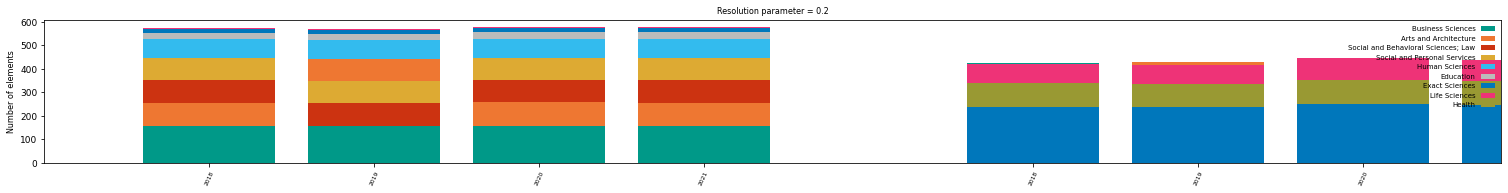

In [8]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(3*17.8*cm,7*cm))

resolution_index = 1
areas_in_comm = {}
for G in networks:
    comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm[G.graph["year"]] = [{area: a.count(area) for area in list(set(a))} for a in comm]
    
max_idx = max(areas_in_comm, key = lambda x: len(areas_in_comm.get(x)))
max_comms_enum = list(enumerate(areas_in_comm[max_idx]))

max_comms = communities_by_resolution[str(max_idx)][resolution_index]

for (year, count), courses in zip(areas_in_comm.items(),list(communities_by_resolution.values())):
    if year == max_idx: 
        areas_in_comm[year] = max_comms_enum
        continue
    areas_in_comm[year] = enumerate_simmilarity(areas_in_comm[year], courses[resolution_index], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm.values())):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)

print(areas_in_comm[2018])
print(sum(areas_in_comm[2018][0][1].values()))
print(sum(areas_in_comm[2018][1][1].values()))

TypeError: enumerate_simmilarity() missing 1 required positional argument: 'max_courses'

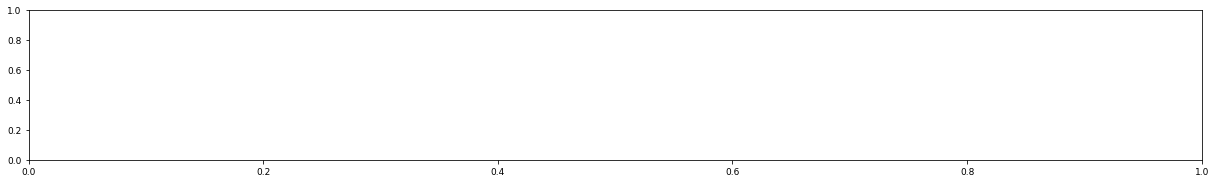

In [12]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(3*17.8*cm,7*cm))

resolution_index = -1
areas_in_comm = []
for G in networks:
    comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)

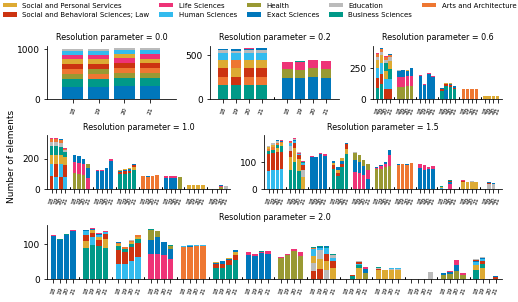

In [17]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
# fig,axes = plt.subplots(nrows=5, figsize=(17.8*cm,5*4*cm))

mosaic = """
EEEAAABBB
CCCCFFFFF
DDDDDDDDD
"""
fig = plt.figure(constrained_layout=False, figsize=(17.8*cm,3*3.5*cm))
ax_dict = fig.subplot_mosaic(mosaic)

# resolution_index = 9
for ax,resolution_index in zip(ax_dict.values(),[0,1,3,5,6,7]):
    areas_in_comm = {}
    for G in networks:
        comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
        areas_in_comm[G.graph["year"]] = [{area: a.count(area) for area in list(set(a))} for a in comm]


    max_idx = max(areas_in_comm, key = lambda x: len(areas_in_comm.get(x)))
    max_comms_enum = list(enumerate(areas_in_comm[max_idx]))

    max_comms = communities_by_resolution[str(max_idx)][resolution_index]
    
    for (year, count), courses in zip(areas_in_comm.items(),list(communities_by_resolution.values())):
        if year == max_idx: 
            areas_in_comm[year] = max_comms_enum
            continue
        areas_in_comm[year] = enumerate_simmilarity(areas_in_comm[year], courses[resolution_index], max_comms)

    for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm.values())):
        y_offset = 0
        for i,area in areas_year:
            y_offset = 0
            parts = list(area.items())
            parts.sort(reverse=True,key = lambda x: x[1])
            for j,(a,count) in enumerate(parts):
                ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
                y_offset += count

    years = list(range(18,22))*len(max_comms)
    idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
    idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        

    ax.set_xticks(idx_minor,minor=True)
    ax.set_xticks(idx,minor=False)
    ax.tick_params(which="minor",axis="x",direction="in")
    ax.set_xticklabels(years, rotation=70, fontdict={"fontsize":6})

    ax.set(xlim=(-1,idx[-1]+1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.set_title(f"Resolution parameter = {resolutions[resolution_index]:.1f}", fontdict={"fontsize":8})

# axes[1].set_ylabel(f"Number of elements", fontdict={"fontsize":8})
fig.text(0.0, 0.50, 'Number of elements', va='center',ha='left',rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
handles, labels = zip(*sorted(list(zip(handles,labels)),key=lambda x: x[1],reverse = True))
by_label = dict(zip(labels, handles))

fig.legend(by_label.values(), by_label.keys(), ncol = 5,loc="upper left", #bbox_to_anchor=(0,1.1), 
            fontsize=7, markerfirst=True, frameon=False,  borderaxespad=0,mode="expand")

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.savefig("images/modularity_communities_by_field.pdf")
# plt.savefig("comm.jpeg",dpi=200)


In [28]:
areas_in_comm

{2018: [(3,
   {'Artes e Arquitetura': 1,
    'Saúde': 29,
    'Ciências Empresariais': 1,
    'Ciências da Vida': 71,
    'Educação': 1,
    'Ciências Exatas': 41}),
  (1,
   {'Humanidades': 12,
    'Ciências Empresariais': 88,
    'Direito, Ciências Sociais e do Comportamento': 16,
    'Serviços Sociais e Pessoais': 21,
    'Ciências da Vida': 2,
    'Ciências Exatas': 2}),
  (0,
   {'Ciências Empresariais': 1,
    'Ciências da Vida': 4,
    'Ciências Exatas': 122}),
  (2,
   {'Artes e Arquitetura': 4,
    'Humanidades': 43,
    'Ciências Empresariais': 11,
    'Direito, Ciências Sociais e do Comportamento': 41,
    'Serviços Sociais e Pessoais': 5,
    'Educação': 1,
    'Ciências Exatas': 1}),
  (4, {'Artes e Arquitetura': 91, 'Ciências Exatas': 2, 'Humanidades': 1}),
  (8,
   {'Artes e Arquitetura': 4,
    'Humanidades': 18,
    'Ciências Empresariais': 2,
    'Direito, Ciências Sociais e do Comportamento': 23,
    'Serviços Sociais e Pessoais': 22,
    'Ciências da Vida': 1,
    

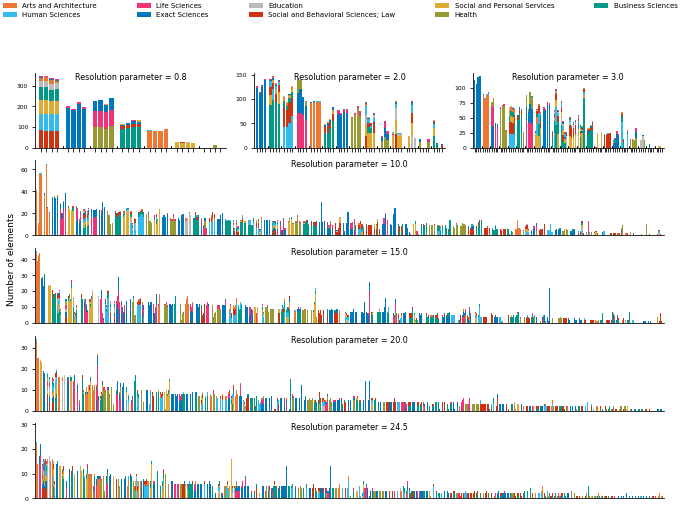

In [73]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))

plt.rcParams.update({'font.size': 9})

x0 = 0


mosaic = """
ABC
DDD
EEE
FFF
GGG
"""
cm = 1/2.54
fig = plt.figure(constrained_layout=False, figsize=(23.5*cm,17.8*cm))
ax_dict = fig.subplot_mosaic(mosaic)

for ax,resolution_index in zip(ax_dict.values(),[4,7,9,23,33,43,52]):
    areas_in_comm = []
    for n, G in enumerate(networks):
        comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
        areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])

    max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
    max_comms = max(areas_in_comm, key = len)
    max_comms_enum = list(enumerate(max_comms))

    for i in range(0,4):
        if i == max_idx: 
            areas_in_comm[i] = max_comms_enum
            continue
        areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)

    for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
        y_offset = 0
        for i,area in areas_year:
            y_offset = 0
            parts = list(area.items())
            parts.sort(reverse=True,key = lambda x: x[1])
            for j,(a,count) in enumerate(parts):
                ax.bar(x0 + i*5+n,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
                y_offset += count

    if resolution_index < 10:
        years = list(range(18,22))*len(max_comms)
        idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
        idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        
        ax.set_xticks(idx_minor,minor=True)
        ax.set_xticks(idx,minor=False)
        ax.tick_params(which="minor",axis="x",direction="in")
        ax.set_xticklabels([""]*len(idx), rotation=65, fontdict={"fontsize":6})
    else:
        years = list(range(18,22))*len(max_comms)
        idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
        idx_minor = [x0 + i*5 + 4 for i in range(len(max_comms)-1) for j in range(4)]        
        ax.set_xticks([],minor=False)
        ax.set_xticklabels([], rotation=65, fontdict={"fontsize":6})


    ax.set(xlim=(-1,idx[-1]+1))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)


    ax.text(0.5,1,f"Resolution parameter = {resolutions[resolution_index]:.1f}", fontsize=8,transform=ax.transAxes,va="top",ha="center")

# axes[1].set_ylabel(f"Number of elements", fontdict={"fontsize":8})
fig.text(0.0, 0.50, 'Number of elements', va='center',ha='left',rotation=90)
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))

fig.legend(by_label.values(), by_label.keys(), ncol = 5,loc="upper left", #bbox_to_anchor=(0,1.1), 
            fontsize=7, markerfirst=True, frameon=False,  borderaxespad=0,mode="expand")

plt.tight_layout()
plt.subplots_adjust(top=0.87)
plt.savefig("images/modularity_communities_by_field_extra.pdf",orientation='landscape')
# plt.savefig("comm.jpeg",dpi=200)


In [55]:
np,where(resolutions[resolutions==1]

array([1.])

**Dimensoes TeX: 17.8 x 23.5**

In [44]:
def simmilarity(x,y,z,w):
    return len(set(x) & set(y) & set(z) & set(w)) #/ (1 + sum([len(set(max([i,j],key=len)) - set(min([i,j],key=len))) for i in [x,y,z,w] for j in [x,y,z,w]])) 
    
# Find matching communities
def enumerate_simmilarity(enum, communities): #communities: list of 4 lists of communities
    max_n_communities = max([len(x) for x in communities])
        
    #Add fake empty communities so all years have the same
    for c in communities:
        c += [[]] * (max_n_communities - len(c))
        
    scores = np.full((max_n_communities,max_n_communities,max_n_communities,max_n_communities),-1)
    
    
    for i in range(max_n_communities):
        for j in range(max_n_communities):
            for k in range(max_n_communities):
                for l in range(max_n_communities):
                    scores[i,j,k,l] = simmilarity(communities[0][i],communities[1][j],communities[2][k],communities[3][l])
    print("Scores calculated")
    result = {}
    for n in range(max_n_communities):
        i,j,k,l = np.unravel_index(scores.argmax(),scores.shape)
        result[n] = [enum[2018][i],enum[2019][j],enum[2020][k],enum[2021][l]]
        scores[i,:,:,:] = -1e6
        scores[:,j,:,:] = -1e6
        scores[:,:,k,:] = -1e6
        scores[:,:,:,l] = -1e6
     
    return result

Scores calculated


IndexError: list index out of range

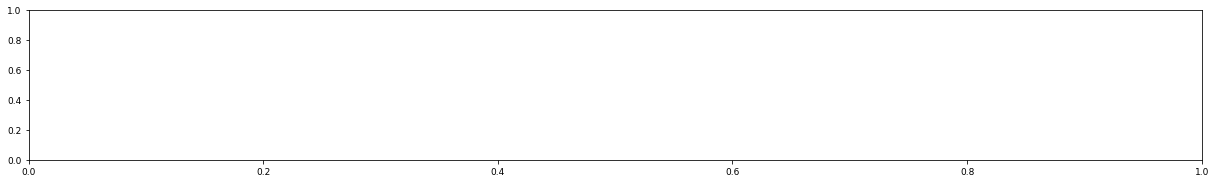

In [38]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
areas  = ['Educação', 'Artes e Arquitetura',
          'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
areas_en  = ['Education', 'Arts and Architecture',
          'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
areas_en=dict(zip(areas,areas_en))
area_colors = dict(zip(areas,colors))
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(3*17.8*cm,7*cm))

resolution_index = 7
areas_in_comm = {}
for G in networks:
    comm = [[G.nodes[y]["area"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm[G.graph["year"]] = [{area: a.count(area) for area in list(set(a))} for a in comm]
    
max_idx = max(areas_in_comm, key = lambda x: len(areas_in_comm.get(x)))
max_comms_enum = list(enumerate(areas_in_comm[max_idx]))

max_comms = communities_by_resolution[str(max_idx)][resolution_index]

areas_in_comm = enumerate_simmilarity(areas_in_comm, [comm[resolution_index] for comm in communities_by_resolution.values()])
print(areas_in_comm[1])
# for (year, count), courses in zip(areas_in_comm.items(),list(communities_by_resolution.values())):
#     if year == max_idx: 
#         areas_in_comm[year] = max_comms_enum
#         continue
#     areas_in_comm[year] = enumerate_simmilarity(areas_in_comm[year], courses[resolution_index], max_comms)
    
for n, areas_year in enumerate(areas_in_comm.values()):
    y_offset = 0
    for i,area in enumerate(areas_year):
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + n*5+i,count,bottom=y_offset,color=area_colors[a],label=areas_en[a])
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)


# Cities

TypeError: enumerate_simmilarity() missing 1 required positional argument: 'max_courses'

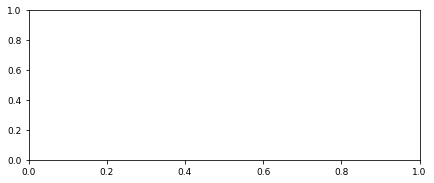

In [54]:
colors = ['#BBBBBB', '#EE7732', '#33BBEE', '#CC3311', '#009988', '#EE3377',  '#0077BB','#DDAA33', '#999933']
# areas  = ['Educação', 'Artes e Arquitetura',
          # 'Humanidades', 'Direito, Ciências Sociais e do Comportamento', 'Ciências Empresariais', 
          # 'Ciências da Vida', 'Ciências Exatas', 'Serviços Sociais e Pessoais', 'Saúde']
# areas_en  = ['Education', 'Arts and Architecture',
          # 'Human Sciences', 'Social and Behavioral Sciences; Law', 'Business Sciences', 
          # 'Life Sciences', 'Exact Sciences', 'Social and Personal Services', 'Health']
# areas_en=dict(zip(areas,areas_en))
# area_colors = dict(zip(areas,colors))
# plt.rcparams()
plt.rcParams.update({'font.size': 9})


x0 = 0

cm = 1/2.54
fig,ax = plt.subplots(figsize=(17.8*cm,7*cm))

resolution_index = 5
areas_in_comm = []
for n, G in enumerate(networks):
    comm = [[G.nodes[y]["faculty_name"] for y in x] for x in communities_by_resolution[str(G.graph["year"])][resolution_index]]
    areas_in_comm.append([{area: a.count(area) for area in list(set(a))} for a in comm])
    
max_idx = areas_in_comm.index(max(areas_in_comm, key = len))
max_comms = max(areas_in_comm, key = len)
max_comms_enum = list(enumerate(max_comms))

for i in range(0,4):
    if i == max_idx: 
        areas_in_comm[i] = max_comms_enum
        continue
    areas_in_comm[i] = enumerate_simmilarity(areas_in_comm[i], max_comms)
    
for n, (G,areas_year) in enumerate(zip(networks,areas_in_comm)):
    y_offset = 0
    for i,area in areas_year:
        y_offset = 0
        parts = list(area.items())
        parts.sort(reverse=True,key = lambda x: x[1])
        for j,(a,count) in enumerate(parts):
            ax.bar(x0 + i*5+n,count,bottom=y_offset)
            y_offset += count

years = list(range(2018,2022))*len(max_comms)
idx = [x0 + i*5 + j for i in range(len(max_comms)) for j in range(4)]        
            
ax.set_xticks(idx)
ax.set_xticklabels(years, rotation=65, fontdict={"fontsize":6})

ax.set(xlim=(-1,ax.get_xlim()[1]-1))

ax.set_title(f"Resolution parameter = {resolutions[resolution_index]}", fontdict={"fontsize":8})

ax.set_ylabel(f"Number of elements", fontdict={"fontsize":8})
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),bbox_to_anchor=(1,1), loc="upper right",
            fontsize=7, markerfirst=False, frameon=False)

plt.tight_layout()
plt.savefig("comm.pdf")
# plt.savefig("comm.jpeg",dpi=200)
